# Overfit? and Regularize House Prices Model

In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do **k-fold cross-validation** to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings("ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

Cleaning...

In [3]:
df.drop(columns='id', inplace=True)

In [4]:
cat_list = ['mssubclass','mszoning','street','alley','lotshape','landcontour','utilities','lotconfig','landslope','neighborhood','condition1','condition2',
            'bldgtype','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond','foundation','bsmtqual','bsmtcond',
            'bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical','kitchenqual','functional','fireplacequ','garagetype',
            'garagefinish','garagequal','garagecond','paveddrive','poolqc','fence','miscfeature','saletype','salecondition', 'overallqual', 'overallcond', 
            'yearbuilt', 'yearremodadd', 'mosold', 'yrsold']
for var in cat_list:
    df[var] = df[var].astype('category')

In [5]:
def add_cat_fillna(variable, new_cat='None'):
    df[variable] = df[variable].cat.add_categories(new_cat).fillna(new_cat).copy()

In [6]:
nulls_list = ['alley','bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','fireplacequ','garagetype','garagefinish','garagequal','garagecond',
             'poolqc','fence','miscfeature']
for var in nulls_list:
    add_cat_fillna(var)

In [7]:
df.masvnrtype = df.masvnrtype.fillna('None').copy()
df.masvnrarea = df.masvnrarea.fillna(0).copy()
df.lotfrontage = df.lotfrontage.fillna(df.lotfrontage.median()).copy()
df.electrical = df.electrical.fillna(df.electrical.mode()[0]).copy()
df.drop(columns='garageyrblt', inplace=True)

In [8]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [9]:
df.drop(outliers_std(df, df.describe().columns), inplace=True)

In [10]:
def do_it_all(X_data, target):
    X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.3, random_state=12)
    
    X_train = sm.add_constant(X_train)
    results = sm.OLS(y_train, X_train).fit()
    print(results.summary())
    
    X_test = sm.add_constant(X_test)
    y_preds = results.predict(X_test)
    
    
    plt.scatter(y_test, y_preds)
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Actual House Prices')
    plt.ylabel('Predicted House Prices')
    plt.title('Predicted vs. Actual House Prices')
    plt.show()

    print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
    print(f'MSE: {mse(y_test, y_preds)}')
    print(f'RMSE: {rmse(y_test, y_preds)}')
    print(f'MAPE: {np.mean(np.abs((y_test - y_preds)/y_test))*100}')

In [11]:
data = pd.DataFrame()
data['target'] = df.saleprice
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['totalsf_grl_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['bedroomabvgr_sf_rel'] = df.bedroomabvgr * (df.totalbsmtsf + df.firstflrsf + df.secondflrsf)
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data = data.join(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True))
data = data.join(pd.get_dummies(df.mssubclass, prefix='mssubclass', drop_first=True))
data.drop(columns=['mszoning_RH', 'mszoning_RM'], inplace=True)
data.drop(columns=['mssubclass_40', 'mssubclass_50', 'mssubclass_60', 'mssubclass_75', 'mssubclass_80', 'mssubclass_85', 'mssubclass_90',
                   'mssubclass_120', 'mssubclass_180', 'mssubclass_190', 'mssubclass_30', 'mssubclass_45'], inplace=True)
data['overallqual'] = df.overallqual.astype(int)
data['overallcond'] = df.overallcond.astype(int)
data['sf_qual_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.overallqual.astype(int)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     222.7
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          2.38e-178
Time:                        17:23:31   Log-Likelihood:                -4827.0
No. Observations:                 431   AIC:                             9682.
Df Residuals:                     417   BIC:                             9739.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.158e+05   3

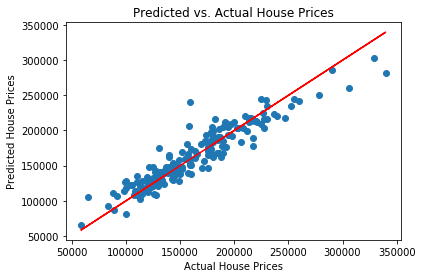

MAE: 12176.827366736465
MSE: 273365577.78924114
RMSE: 16533.770827891654
MAPE: 7.917380402260717


In [12]:
target1 = data['target']
X_data1 = data.iloc[:, 1:]
do_it_all(X_data1, target1)

In [13]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

In [14]:
ridgecv = RidgeCV(alphas=np.logspace(-20, 20, 13), normalize=True)
lassocv = LassoCV(normalize=True)
elastcv = ElasticNetCV(l1_ratio=[0.000000000001, .1, .5, .7, .9, .95, .99, 1], normalize=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data1, target1, test_size=.3, random_state=12)

In [16]:
ridgecv.fit(X_data1, target1)

RidgeCV(alphas=array([1.00000000e-20, 2.15443469e-17, 4.64158883e-14, 1.00000000e-10,
       2.15443469e-07, 4.64158883e-04, 1.00000000e+00, 2.15443469e+03,
       4.64158883e+06, 1.00000000e+10, 2.15443469e+13, 4.64158883e+16,
       1.00000000e+20]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
        scoring=None, store_cv_values=False)

In [17]:
ridgecv.alpha_

0.00046415888336127914

In [18]:
lassocv.fit(X_data1, target1)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [19]:
lassocv.alpha_

1.7419337643983486

In [20]:
elastcv.fit(X_data1, target1)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=[1e-12, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=True, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [21]:
elastcv.alpha_, elastcv.l1_ratio_

(1.7419337643983486, 1.0)

In [22]:
ridge_y_train = ridgecv.predict(X_train)
ridge_y_test = ridgecv.predict(X_test)

lasso_y_train = lassocv.predict(X_train)
lasso_y_test = lassocv.predict(X_test)

elast_y_train = elastcv.predict(X_train)
elast_y_test = elastcv.predict(X_test)

In [23]:
print("R-squared of the model in the training set is: {}".format(ridgecv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridgecv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, ridge_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, ridge_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, ridge_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - ridge_y_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8728664338652085
-----Test set statistics-----
R-squared of the model in the test set is: 0.8823365274572776
Mean absolute error of the prediction is: 11905.786723306315
Mean squared error of the prediction is: 256661203.7848922
Root mean squared error of the prediction is: 16020.649293486584
Mean absolute percentage error of the prediction is: 7.714636007393608


In [24]:
print("R-squared of the model in the training set is: {}".format(lassocv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lassocv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, lasso_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, lasso_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, lasso_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - lasso_y_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8723457013418716
-----Test set statistics-----
R-squared of the model in the test set is: 0.882136710333806
Mean absolute error of the prediction is: 11894.023216858921
Mean squared error of the prediction is: 257097068.05388543
Root mean squared error of the prediction is: 16034.246725489958
Mean absolute percentage error of the prediction is: 7.670872550209936


In [25]:
print("R-squared of the model in the training set is: {}".format(elastcv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elastcv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, elast_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, elast_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, elast_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - elast_y_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8723457013418716
-----Test set statistics-----
R-squared of the model in the test set is: 0.882136710333806
Mean absolute error of the prediction is: 11894.023216858921
Mean squared error of the prediction is: 257097068.05388543
Root mean squared error of the prediction is: 16034.246725489958
Mean absolute percentage error of the prediction is: 7.670872550209936


After normalization, it looks like both methods come up with practically the same results (ElasticNet simply defaults to Lasso since L1_Ratio cannot be zero). The Ridge method appears to slightly edge the Lasso and ElasticNet method when it comes to R-squared values (but the difference is miniscule). All the other evaluation metrics are also nearly identical, but it looks like the Lasso method is better in every aspect except R-square (also by a miniscule amount). It appears that both these methods should obtain relatively optimal results.